# Ridge regression
**Important**: Change the kernel to *PROJECT_NAME local*. You can do this from the *Kernel* menu under *Change kernel*.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
import pickle
import os
import scipy.stats as st

In [ ]:
from azureml.logging import get_azureml_logger
run_logger = get_azureml_logger()
run_logger.log('amlrealworld.timeseries.ridge','true')

In [3]:
model_name = "ridge"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(os.path.join(aml_dir, 'nyc_demand_train.csv'), parse_dates=['timeStamp'])

Create model pipeline:
- **one-hot encode categorical variables**
- **randomized parameter search** with cross validation to find optimal values for the alpha parameter

Fitting this pipeline should take less than a minute.

In [4]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [5]:
cat_cols = ['hour', 'month', 'dayofweek']
cat_cols_idx = [X.columns.get_loc(c) for c in X.columns if c in cat_cols]
onehot = OneHotEncoder(categorical_features=cat_cols_idx, sparse=False)
regr = Ridge(fit_intercept=False)
tscv = TimeSeriesSplit(n_splits=3)

In [6]:
param_dist = {'alpha': st.uniform(1e-4, 10.0)}
regr_cv = RandomizedSearchCV(estimator=regr,
                            param_distributions=param_dist,
                            n_iter=100,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            cv=tscv,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('onehot', onehot), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   12.9s finished


Pipeline(steps=[('onehot', OneHotEncoder(categorical_features=[2, 3, 4], dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)), ('regr_cv', RandomizedSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_int...it=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2))])

In [7]:
with open(os.path.join(aml_dir, model_name + '.pkl'), 'wb') as f:
    pickle.dump(regr_pipe, f)

Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score').head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
49,0.089835,0.006168,-3878.859395,-4220.967056,6.49913,{'alpha': 6.49912577285},1,-4167.935766,-4384.068902,-3678.923700,-4237.816380,-3789.718719,-4041.015886,0.033066,0.002393,209.352566,140.556674
38,0.087167,0.003672,-3878.860897,-4220.383619,6.07326,{'alpha': 6.07326031928},2,-4167.276157,-4382.857228,-3679.182119,-4237.453682,-3790.124415,-4040.839947,0.030801,0.000940,208.909182,140.148720
41,0.204834,0.013664,-3878.862970,-4220.321732,6.02709,{'alpha': 6.02709056681},3,-4167.208182,-4382.728418,-3679.211411,-4237.415367,-3790.169318,-4040.821411,0.049504,0.004988,208.862212,140.105305
17,0.060001,0.002500,-3878.864722,-4221.139403,6.62191,{'alpha': 6.62191382787},4,-4168.136558,-4384.425942,-3678.853064,-4237.924014,-3789.604544,-4041.068253,0.012296,0.000001,209.483681,140.676741
23,0.065000,0.002667,-3878.867951,-4221.217791,6.67734,{'alpha': 6.67733989627},5,-4168.228705,-4384.588205,-3678.821738,-4237.973040,-3789.553410,-4041.092128,0.008154,0.000623,209.543329,140.731287


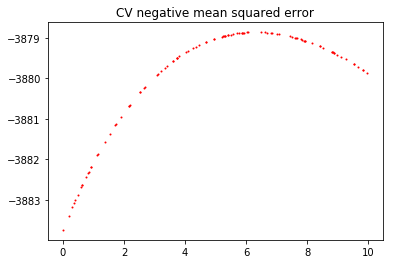

In [9]:
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], 'ro', markersize=1)
plt.title('CV negative mean squared error')
plt.show()